# BBC News Article Classifier
A multi-class news classification model trained on the BBC dataset using TF-IDF and logistic regression. Built and analyzed using Azure ML to demonstrate end-to-end NLP workflow.


## Dataset Description
The dataset contains 2,225 BBC news articles categorized into five classes:
- `business`
- `entertainment`
- `politics`
- `sport`
- `tech`

Each document is stored as a `.txt` file in a folder named after its category.


## Data Loading and Initial Preprocessing

- Loaded raw `.txt` files from BBC news dataset directory.
- Combined them into a structured Pandas DataFrame with `text` and `category` columns.
- Shuffled the dataset for unbiased training/testing splits.


In [1]:
import os
import pandas as pd

DATA_DIR = "bbc"

data = []

# Traverse each category folder (business, tech, etc.)
for category in os.listdir(DATA_DIR):
    category_path = os.path.join(DATA_DIR, category)
    
    if not os.path.isdir(category_path):
        continue
    
    for filename in os.listdir(category_path):
        file_path = os.path.join(category_path, filename)
        try:
            with open(file_path, 'r', encoding='latin-1') as file:
                text = file.read().strip().replace('\n', ' ')
                data.append({'text': text, 'category': category})
        except Exception as e:
            print(f"Error reading {file_path}: {e}")

# Convert to DataFrame and shuffle
df = pd.DataFrame(data)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)


df.head()


,text,category
0,UK house prices dip in November UK house pric...,business
1,LSE 'sets date for takeover deal' The London ...,business
2,Harinordoquy suffers France axe Number eight ...,sport
3,Barclays shares up on merger talk Shares in U...,business
4,Campaign 'cold calls' questioned Labour and t...,politics


In [2]:
# Save cleaned data for reuse
df.to_csv("bbc_preprocessed.csv", index=False)
print("Saved as bbc_preprocessed.csv")


Saved as bbc_preprocessed.csv


## Class Distribution Visualization

- Visualized the number of articles in each BBC news category using a count plot.
- Helps identify class imbalance and understand dataset structure before training.


/tmp/ipykernel_3850/3010782349.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='category', palette='viridis')


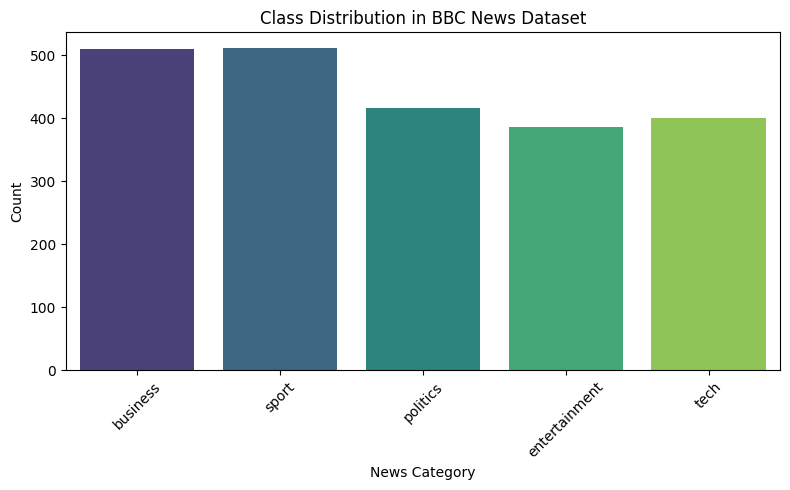

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.countplot(data=df, x='category', palette='viridis')
plt.title("Class Distribution in BBC News Dataset")
plt.xlabel("News Category")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Text Cleaning and Lemmatization

- Downloaded necessary NLTK resources: stopwords, tokenizer, and WordNet lemmatizer.
- Applied text normalization: lowercasing, punctuation/digit removal, stopword filtering, and lemmatization.
- Created a new column `clean_text` for the processed version of each article.


In [4]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation and digits
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize and remove stopwords
    tokens = [word for word in text.split() if word not in stop_words]
    # Lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

# Apply cleaning
df['clean_text'] = df['text'].apply(clean_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/azureuser/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## TF-IDF Vectorization and Data Splitting

- Split the cleaned dataset into training and test sets using an 80/20 ratio.
- Applied TF-IDF vectorization with a vocabulary size of 5,000 to convert text into numerical features.
- Removed English stopwords during vectorization to improve signal-to-noise ratio.


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df["clean_text"], df["category"], test_size=0.2, random_state=42
)


# Initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)

# Fit on training data, transforming both train & test
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print("TF-IDF transformation complete.")


TF-IDF transformation complete.


## Model Training: Logistic Regression

- Trained a Logistic Regression classifier on the TF-IDF-transformed training set.
- Increased `max_iter` to 1000 to ensure model convergence.


In [6]:
from sklearn.linear_model import LogisticRegression

# Initialize and training the logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

print("Model training complete.")


Model training complete.


## Model Evaluation

- Predicted categories on the test set using the trained Logistic Regression model.
- Evaluated performance using `accuracy_score` and `classification_report` (precision, recall, f1-score per class).
- Achieved a final accuracy of **96.4%** across 5 BBC news categories.


In [7]:
from sklearn.metrics import classification_report, accuracy_score

# Predict on test set
y_pred = model.predict(X_test_tfidf)

# Show evaluation results
print(" Classification Report:\n")
print(classification_report(y_test, y_pred))

print(" Accuracy Score:", accuracy_score(y_test, y_pred))


 Classification Report:

               precision    recall  f1-score   support

     business       0.94      0.96      0.95       102
entertainment       0.99      0.96      0.97        72
     politics       0.96      0.93      0.94        72
        sport       0.98      0.99      0.99       110
         tech       0.97      0.98      0.97        89

     accuracy                           0.97       445
    macro avg       0.97      0.96      0.97       445
 weighted avg       0.97      0.97      0.97       445

 Accuracy Score: 0.9662921348314607


In [8]:
import joblib

# Save model and vectorizer to local files
joblib.dump(model, "bbc_logistic_model.pkl")
joblib.dump(vectorizer, "bbc_tfidf_vectorizer.pkl")

print(" Saved model and vectorizer as .pkl files.")


 Saved model and vectorizer as .pkl files.


## Model Interpretability and Visualizations

- Plotted a confusion matrix to analyze model performance across all five categories.
- Generated category-wise WordClouds to visualize the most frequent and impactful terms in each class.
- Displayed top 10 informative features per class based on logistic regression coefficients.


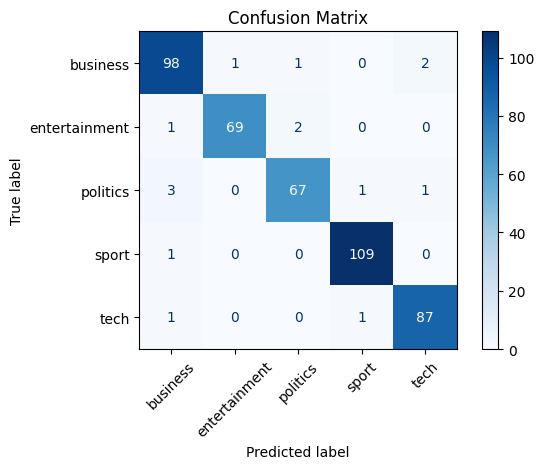

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


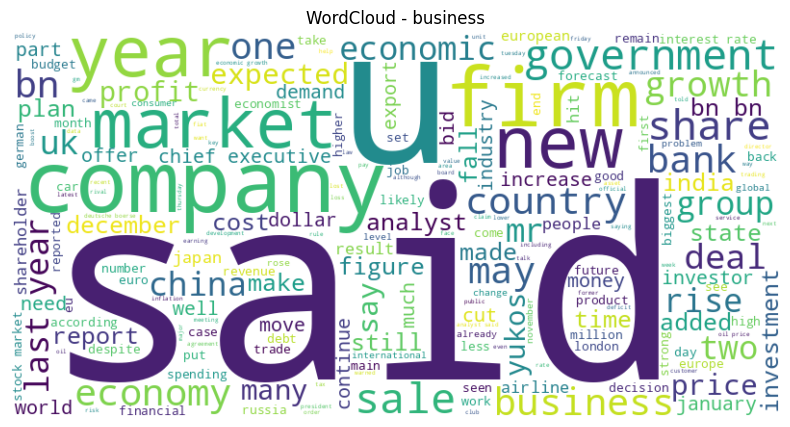

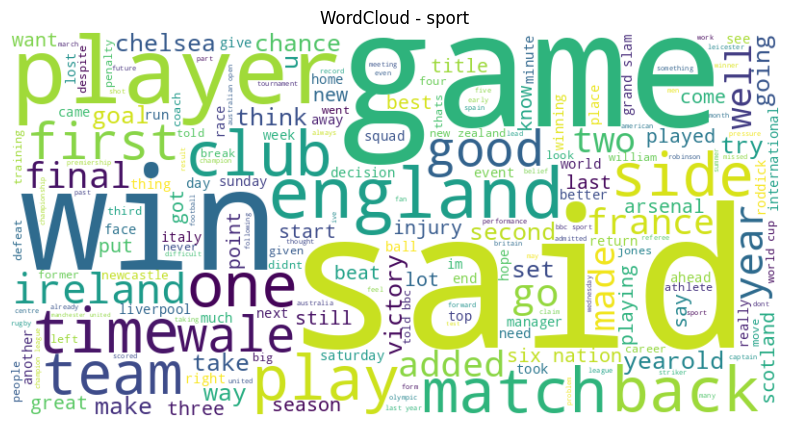

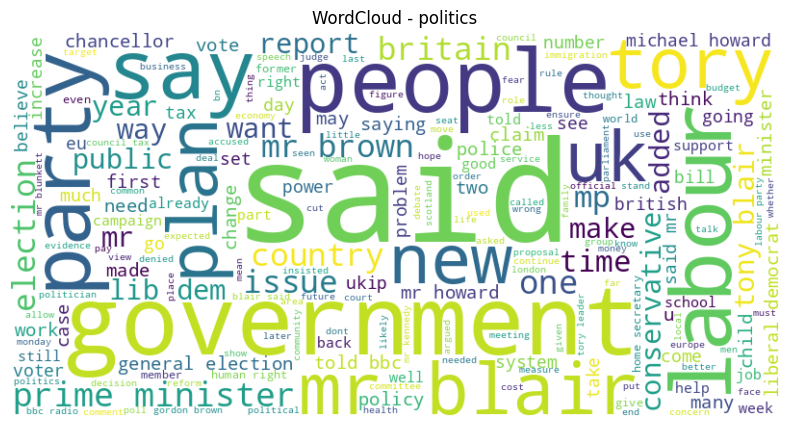

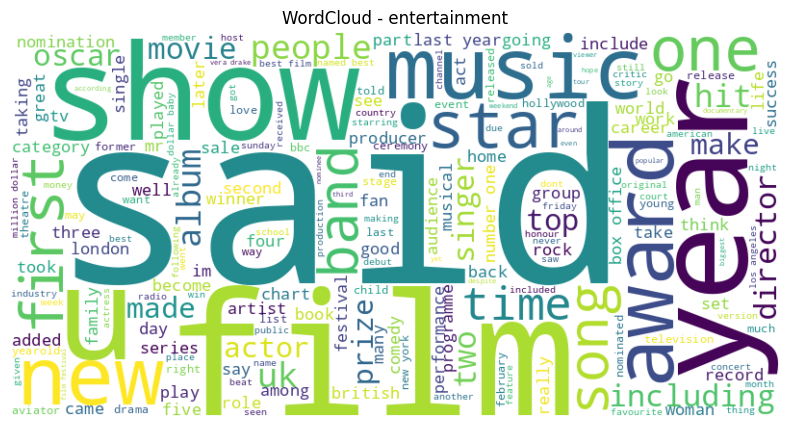

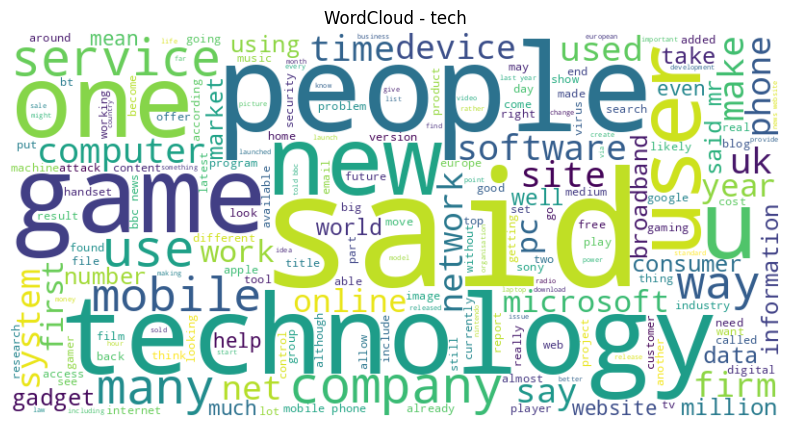

In [10]:
from wordcloud import WordCloud

for category in df['category'].unique():
    text = " ".join(df[df['category'] == category]['clean_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud - {category}")
    plt.show()


In [11]:
print("Top 10 most informative features:")
feature_names = vectorizer.get_feature_names_out()
coefs = model.coef_
for i, category in enumerate(model.classes_):
    top10 = coefs[i].argsort()[-10:][::-1]
    print(f"\nCategory: {category}")
    for idx in top10:
        print(f"{feature_names[idx]} ({coefs[i][idx]:.2f})")


Top 10 most informative features:

Category: business
bn (2.72)
company (2.26)
bank (2.21)
firm (2.04)
market (1.99)
share (1.95)
price (1.74)
economy (1.66)
economic (1.49)
oil (1.48)

Category: entertainment
film (3.93)
star (1.99)
band (1.85)
album (1.79)
music (1.72)
singer (1.70)
award (1.69)
chart (1.54)
actor (1.43)
tv (1.41)

Category: politics
mr (2.51)
party (2.36)
labour (2.20)
government (2.06)
blair (2.02)
minister (1.96)
lord (1.79)
tory (1.77)
election (1.74)
mp (1.48)

Category: sport
match (1.88)
player (1.76)
cup (1.69)
coach (1.63)
win (1.63)
champion (1.55)
club (1.48)
injury (1.48)
rugby (1.39)
england (1.33)

Category: tech
technology (2.18)
software (2.14)
game (2.13)
computer (2.05)
user (2.01)
mobile (1.95)
phone (1.73)
people (1.67)
site (1.63)
digital (1.61)


## 🔍 Single Sample Prediction (Inference)

- Entered a news headline to test the model in a real-world scenario.
- Applied the same preprocessing and TF-IDF vectorization pipeline.
- Predicted the category using the trained model — demonstrating practical use of the classifier.


In [12]:
#text input
sample_text = ["Apple releases new iPhone with advanced AI features and camera improvements"]

# Preprocess like training
sample_cleaned = [clean_text(text) for text in sample_text]
sample_vect = vectorizer.transform(sample_cleaned)

# Predict
prediction = model.predict(sample_vect)
print(f" Predicted Category: {prediction[0]}")


 Predicted Category: tech


In [13]:
texts = [
    "The stock market saw a significant drop after inflation reports were released",
    "Manchester United secured a thrilling 3-2 victory in the Champions League",
    "Government proposes new reforms in the education sector",
    "Taylor Swift's latest album breaks streaming records worldwide"
]

# Clean, vectorize, and predict
cleaned = [clean_text(t) for t in texts]
vect = vectorizer.transform(cleaned)
preds = model.predict(vect)


for t, p in zip(texts, preds):
    print(f"\n Text: {t}\n Predicted Category: {p}")



 Text: The stock market saw a significant drop after inflation reports were released
 Predicted Category: business

 Text: Manchester United secured a thrilling 3-2 victory in the Champions League
 Predicted Category: sport

 Text: Government proposes new reforms in the education sector
 Predicted Category: politics

 Text: Taylor Swift's latest album breaks streaming records worldwide
 Predicted Category: entertainment


## Model Deployment: Scoring Script (`score.py`)

- Defined `init()` to load the saved logistic regression model and TF-IDF vectorizer.
- Defined `run()` to accept raw JSON input, apply TF-IDF transformation, and return predicted categories.
- This script enables the model to be deployed as a REST API using Azure ML endpoints.


In [14]:
import json
import joblib
import numpy as np

def init():
    global model, vectorizer
    model = joblib.load("bbc_logistic_model.pkl")
    vectorizer = joblib.load("bbc_tfidf_vectorizer.pkl")

def run(raw_data):
    try:
        data = json.loads(raw_data)["text"]
        if isinstance(data, str):
            data = [data]
        vectorized = vectorizer.transform(data)
        prediction = model.predict(vectorized)
        return json.dumps({"prediction": prediction.tolist()})
    except Exception as e:
        return json.dumps({"error": str(e)})
